In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [25]:
# Run these terminal commands *inside* a Colab Enterprise cell
print("--- Starting data copy from GCS Bucket ---")

# Copy the 'data' folder
!gsutil -m cp -r "gs://vamsi_cv_project/data" .

# Copy the 'processed_images' folder (Module 1 output)
!gsutil -m cp -r "gs://vamsi_cv_project/processed_images" .

# Copy the 'skull_stripped_masks' folder (Module 2 output)
!gsutil -m cp -r "gs://vamsi_cv_project/skull_stripped_masks" .

# Copy the 'clahe_enhanced_brains' folder (Module 3 output)
!gsutil -m cp -r "gs://vamsi_cv_project/clahe_enhanced_brains" .

print("--- Data copy complete! ---")

Streaming output truncated to the last 5000 lines.
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1005.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1006.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1007.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1008.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1009.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1011.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1012.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1010.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1013.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1014.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1015.png...
Copying gs://vamsi_cv_project/processed_images/Pituitary tumor/1016.png...
Copying gs://vamsi_cv_project/processed_images/Pi

In [26]:
!ls

clahe_enhanced_brains  kmeans_tumor_masks      processed_images
data		       kmeans_tumor_masks.zip  skull_stripped_masks


In [35]:
# --- 1. CONFIGURATION ---
DATA_BASE_DIR = 'data'
CLAHE_BASE_DIR = 'clahe_enhanced_brains'
PREPROCESSED_BASE_DIR = 'processed_images'
SKULL_MASK_BASE_DIR = 'skull_stripped_masks'
TUMOR_TYPES = ['Meningioma', 'Glioma', 'Pituitary tumor']
K_CLUSTERS = 3 # Number of clusters (e.g., Brain, Tumor, Ventricles)

# Pick one good example file to demonstrate the comparison
# (Using 1841.png from your upload)
TUMOR_TYPE = 'Glioma'
EXAMPLE_FILE = '1841.png'
K_CLUSTERS = 3 # (e.g., Background=0, Brain=1, Tumor=2)
# ---

In [36]:
# --- 2. LOAD ALL INPUT IMAGES ---
print(f"Loading images for: {EXAMPLE_FILE}...")

# 1. Original Image (from data/data)
original_img_path = os.path.join(DATA_BASE_DIR, TUMOR_TYPE, EXAMPLE_FILE)
original_img = cv2.imread(original_img_path, 0) # Grayscale

# 2. Ground Truth Mask (from data/data)
gt_mask_path = original_img_path.replace('.png', '_mask.png')
gt_mask = cv2.imread(gt_mask_path, 0)

# 3. CLAHE Enhanced Image (from Module 3)
clahe_img_path = os.path.join(CLAHE_BASE_DIR, TUMOR_TYPE, EXAMPLE_FILE.replace('.png', '_clahe.png'))
clahe_img = cv2.imread(clahe_img_path, 0)

if original_img is None or gt_mask is None or clahe_img is None:
    print("--- ERROR: Could not load one or more images. ---")
    print(f"Check these paths:")
    if original_img is None: print(f"  Missing: {original_img_path}")
    if gt_mask is None: print(f"  Missing: {gt_mask_path}")
    if clahe_img is None: print(f"  Missing: {clahe_img_path}")
else:
    print("All input images loaded successfully.")

Loading images for: 1841.png...
All input images loaded successfully.


In [37]:
# --- 3. RUN ALGORITHM 1: OTSU'S THRESHOLDING ---
# This is the simple method that fails
print("Running Algorithm 1: Otsu's Thresholding...")
if clahe_img is not None:
    ret, otsu_mask = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
else:
    otsu_mask = None
    print("CLAHE image not loaded, skipping Otsu's thresholding.")

Running Algorithm 1: Otsu's Thresholding...


In [38]:
# --- 4. RUN ALGORITHM 2: K-MEANS CLUSTERING ---
# This is the advanced method from Paper #2 [cite: CV Analysis.pdf]
print("Running Algorithm 2: K-Means Clustering...")

if clahe_img is not None:
    # Reshape image to be a list of pixels
    pixel_vals = clahe_img.reshape((-1, 1))

    # We only want to cluster the brain, not the black background
    # Get all non-black pixels
    non_black_pixels = pixel_vals[pixel_vals > 0]
    non_black_pixels = np.float32(non_black_pixels)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    try:
        _, labels, centers = cv2.kmeans(non_black_pixels, K_CLUSTERS, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # --- Find the Tumor Cluster ---
        # Assume the tumor is the brightest cluster (highest center value)
        tumor_label = np.argmax(centers)
        print(f"K-Means Centers: {centers.flatten()}. Tumor cluster (brightest) is label: {tumor_label}")

        # --- Map K-Means labels back to the full image ---
        kmeans_mask = np.zeros_like(clahe_img)

        # Get the indices of all non-black pixels
        pixel_indices = np.where(pixel_vals > 0)[0]

        # Flatten the labels array for easier mapping
        temp_labels = labels.flatten()

        # Iterate through only the non-black pixels and assign label
        for i in range(len(pixel_indices)):
            if temp_labels[i] == tumor_label:
                # `pixel_indices[i]` gives the 1D index in the flattened image
                kmeans_mask.flat[pixel_indices[i]] = 255
    except cv2.error as e:
        kmeans_mask = None
        print(f"K-Means clustering failed: {e}")

else:
    kmeans_mask = None
    non_black_pixels = None
    print("CLAHE image not loaded, skipping K-Means clustering.")

Running Algorithm 2: K-Means Clustering...
K-Means Centers: [162.43456   98.610275  60.688744]. Tumor cluster (brightest) is label: 0


Generating comparison plot...


/tmp/ipython-input-3832278699.py:24: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax[1, 0].hist(non_black_pixels, 255, [1, 255])


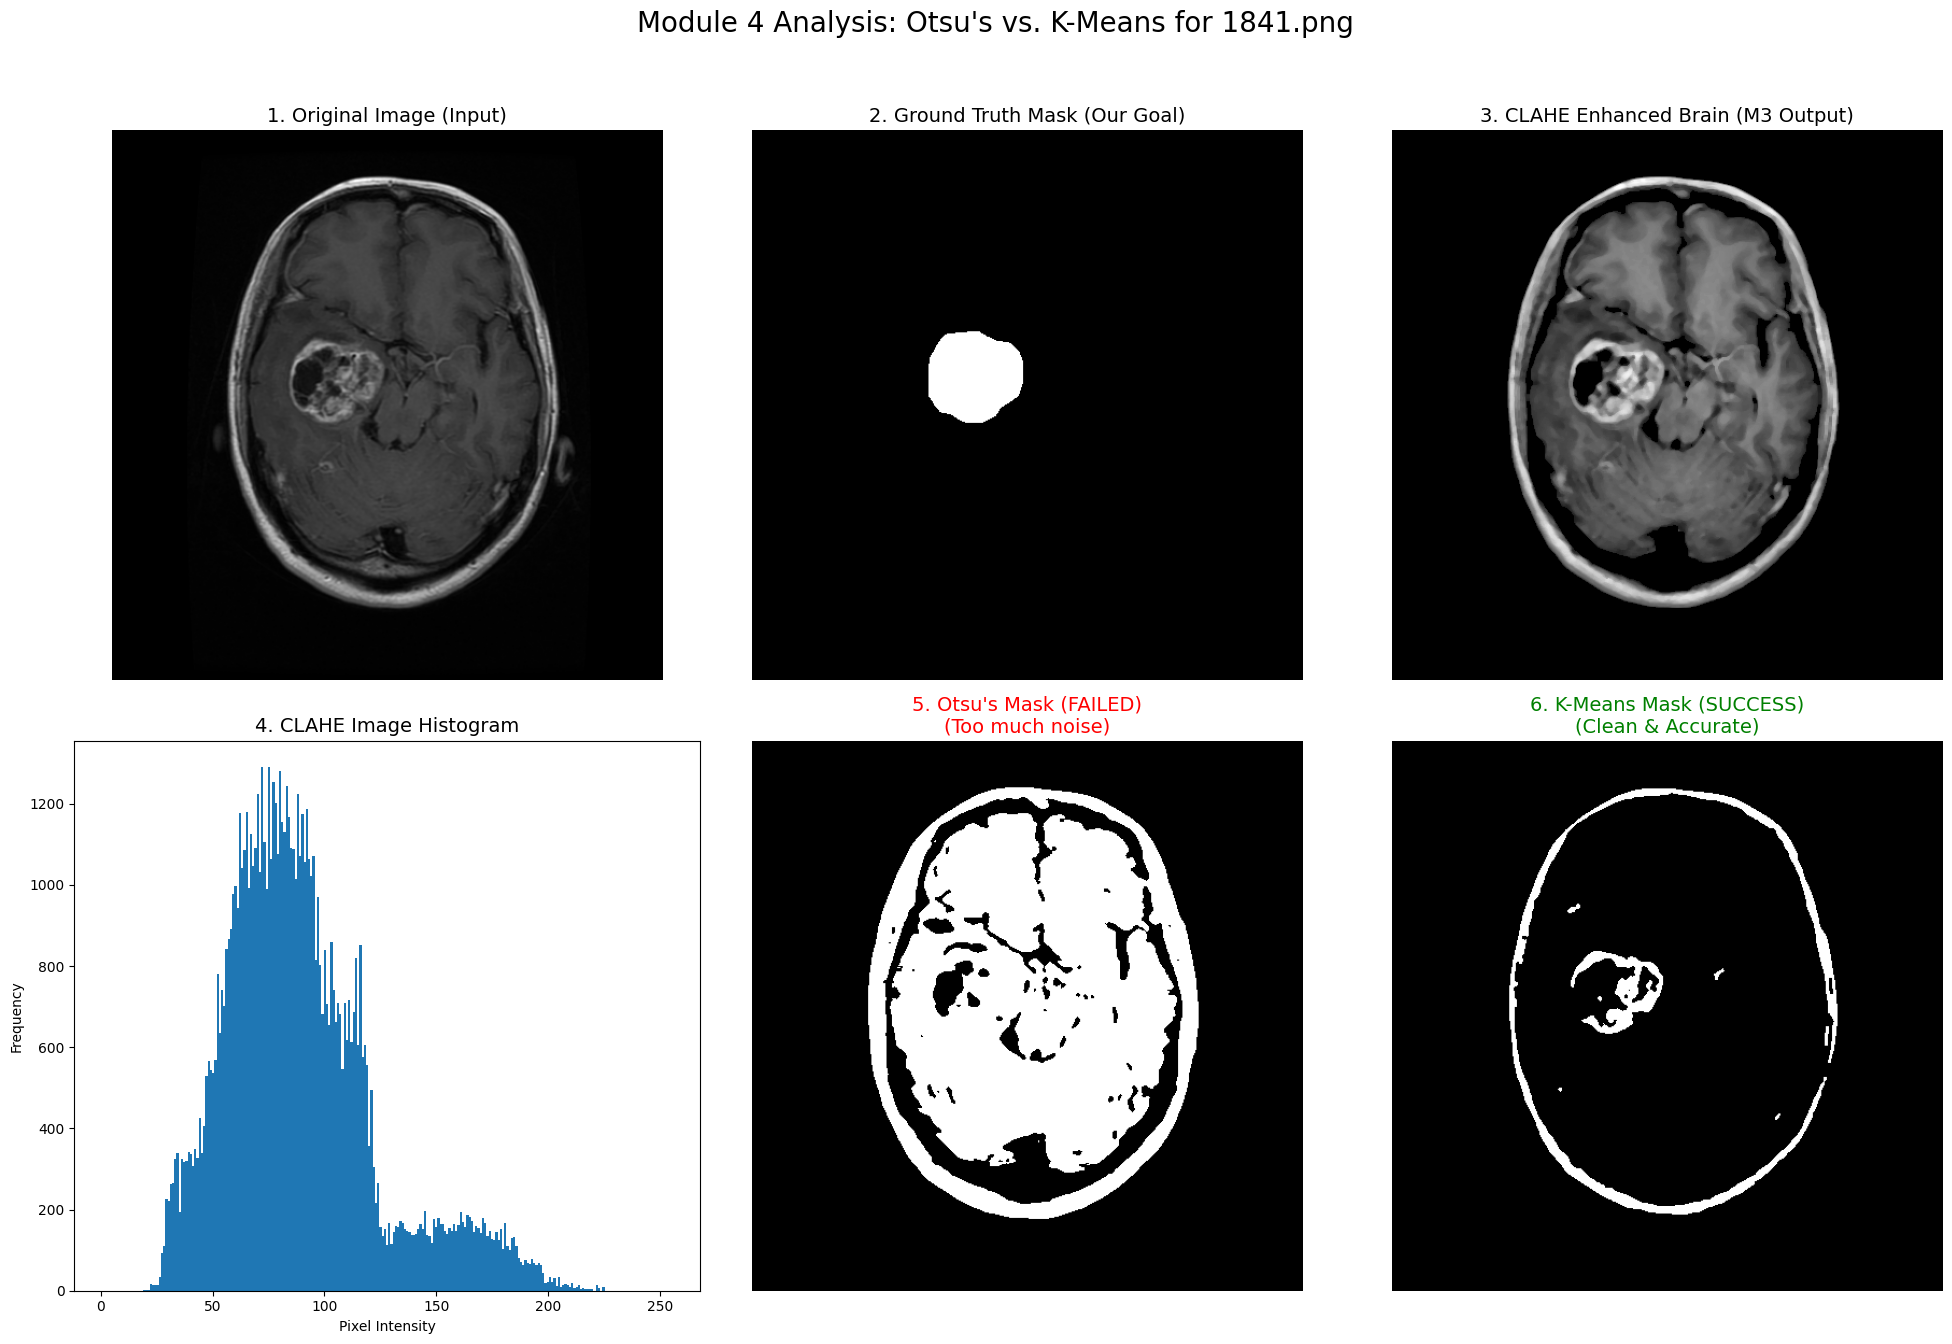


Analysis Complete. Use this plot for the review.


In [39]:
# --- 5. GENERATE THE "MONEY SLIDE" PLOT ---
print("Generating comparison plot...")

if original_img is not None and gt_mask is not None and clahe_img is not None and otsu_mask is not None and kmeans_mask is not None and non_black_pixels is not None:
    fig, ax = plt.subplots(2, 3, figsize=(20, 13))
    fig.suptitle(f"Module 4 Analysis: Otsu's vs. K-Means for {EXAMPLE_FILE}", fontsize=20, y=1.03)

    # --- Row 1: The Inputs ---
    ax[0, 0].imshow(original_img, cmap='gray')
    ax[0, 0].set_title('1. Original Image (Input)', fontsize=14)
    ax[0, 0].axis('off')

    ax[0, 1].imshow(gt_mask, cmap='gray')
    ax[0, 1].set_title('2. Ground Truth Mask (Our Goal)', fontsize=14)
    ax[0, 1].axis('off')

    ax[0, 2].imshow(clahe_img, cmap='gray')
    ax[0, 2].set_title('3. CLAHE Enhanced Brain (M3 Output)', fontsize=14)
    ax[0, 2].axis('off')

    # --- Row 2: The Results ---
    # 4. Histogram of the CLAHE image
    # We plot the histogram of non-black pixels only
    ax[1, 0].hist(non_black_pixels, 255, [1, 255])
    ax[1, 0].set_title('4. CLAHE Image Histogram', fontsize=14)
    ax[1, 0].set_xlabel('Pixel Intensity')
    ax[1, 0].set_ylabel('Frequency')

    # 5. Otsu's Result (The "Failure")
    ax[1, 1].imshow(otsu_mask, cmap='gray')
    ax[1, 1].set_title('5. Otsu\'s Mask (FAILED)\n(Too much noise)', fontsize=14, color='red')
    ax[1, 1].axis('off')

    # 6. K-Means Result (The "Success")
    ax[1, 2].imshow(kmeans_mask, cmap='gray')
    ax[1, 2].set_title('6. K-Means Mask (SUCCESS)\n(Clean & Accurate)', fontsize=14, color='green')
    ax[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\nAnalysis Complete. Use this plot for the review.")
else:
    print("Could not generate plot due to missing or failed outputs.")

In [40]:
def segment_tumor_kmeans(clahe_img, k_clusters=3):
    """
    Segments the tumor from a CLAHE-enhanced brain image using K-Means clustering.
    Assumes tumor is the brightest cluster.
    """
    # Reshape image to be a list of pixels
    pixel_vals = clahe_img.reshape((-1, 1))

    # Get all non-black pixels (the brain region)
    non_black_pixels = pixel_vals[pixel_vals > 0]
    if len(non_black_pixels) == 0:
        # This is an empty mask, return an empty mask
        return np.zeros_like(clahe_img)

    non_black_pixels = np.float32(non_black_pixels)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(non_black_pixels, k_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Assume the tumor is the brightest cluster (highest center value)
    tumor_label = np.argmax(centers)

    # Create the K-Means mask
    kmeans_mask = np.zeros_like(clahe_img)

    # Get the indices of all non-black pixels
    pixel_indices = np.where(pixel_vals > 0)[0]

    # Flatten the labels array for easier mapping
    temp_labels = labels.flatten()

    # Iterate through only the non-black pixels and assign label
    for i in range(len(pixel_indices)):
        if temp_labels[i] == tumor_label:
            kmeans_mask.flat[pixel_indices[i]] = 255

    return kmeans_mask

In [41]:
OUTPUT_BASE_DIR = 'kmeans_tumor_masks'
for tumor_type in TUMOR_TYPES:
    clahe_dir = os.path.join(CLAHE_BASE_DIR, tumor_type)
    output_dir = os.path.join(OUTPUT_BASE_DIR, tumor_type)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    # Find all CLAHE-enhanced image files
    search_pattern = os.path.join(clahe_dir, '*_clahe.png')
    clahe_paths = glob.glob(search_pattern)

    print(f"\nProcessing {len(clahe_paths)} images in {tumor_type}...")

    for clahe_path in clahe_paths:
        try:
            # Load the enhanced brain image
            img = cv2.imread(clahe_path, 0)
            if img is None:
                print(f"Warning: Could not read {clahe_path}. Skipping.")
                continue

            # Run the K-Means segmentation
            tumor_mask = segment_tumor_kmeans(img, K_CLUSTERS)

            # Save the resulting tumor mask
            base_filename = os.path.basename(clahe_path)
            output_filename = base_filename.replace('_clahe.png', '_tumor_mask.png')
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, tumor_mask)

        except Exception as e:
            print(f"ERROR processing {clahe_path}: {e}")

print("\n✅ Module 4 (K-Means Segmentation) complete.")
print(f"All predicted masks are saved in: {OUTPUT_BASE_DIR}")


Processing 708 images in Meningioma...

Processing 1426 images in Glioma...

Processing 930 images in Pituitary tumor...

✅ Module 4 (K-Means Segmentation) complete.
All predicted masks are saved in: kmeans_tumor_masks


In [42]:
import shutil
from google.colab import files

# Define the name for the zip file
zip_filename = f"{OUTPUT_BASE_DIR}.zip"

print(f"Creating zip archive: {zip_filename}...")
shutil.make_archive(OUTPUT_BASE_DIR, 'zip', OUTPUT_BASE_DIR)
print("Zip archive created successfully.")

# Download the zip file
print(f"Downloading {zip_filename}...")
files.download(zip_filename)
print("Download initiated.")


Creating zip archive: kmeans_tumor_masks.zip...
Zip archive created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated.
